![](https://i.imgur.com/iWtMWh7.png)

# Table Of Contents
* [Introduction](#intro)
* [Import Libraries](#libraries)
* [Dataset Files](#Dataset_Files)
    - [Load Dataset](#Load_Dataset)
* [5-Level classification modification](#5_Level_classification_modification)
* [Initial Observation](#Initial_Observation)
* [Visualization](#Visualization)
    - [Correlation Analysis](#Correlation_Analysis)
    - [Categorical Quantitative Insights](#Categorical_Quantitative_Insights)
    - [Non-Categorical Quantitative Insights](#Non_Categorical_Quantitative_Insights)
    - [Skewness & Kurtosis](#Skewness_Kurtosis)
* [Outliers Detection](#Outliers_Detection)
* [Classification Modeling](#Classification_Modeling)
    - [Data Scaling](#Data_Scaling)
* [Conclusions](#Conclusions)


<a id="intro"></a>
# Introduction
Before I even started with this kernel I saw that there this is an actual study (source can be found here [5-Level classification modification](#5_Level_classification_modification)) and I read the paper, the researcher had some ideas of what to actually learn from it, one of those ideas was the 5 level classification model, which **I took and added a little twist: instead of classifying the `G3` grade, I actually took the annual average and classified it according to that paper.**

Since I didn't work that much with `Seaborn` until now, I wanted to see how much information I could extract from the data with the different types of plots, so there are a lot of those here.

<a id="libraries"></a>
# Import Libraries

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


<a id="Dataset_Files"></a>
# Dataset Files

In [47]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/student-performance-data-set/student-por.csv


<a id="Load_Dataset"></a>
# Load Dataset

In [48]:
students_grades_df = pd.read_csv(
    '../input/student-performance-data-set/student-por.csv')


## Attribute Information: (taken from [archive.ics.uci.edu](https://archive.ics.uci.edu/ml/datasets/Student+Performance))
### Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
### 1. ***school*** - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
### 2. ***sex*** - student's sex (binary: 'F' - female or 'M' - male)
### 3. ***age*** - student's age (numeric: from 15 to 22)
### 4. ***address*** - student's home address type (binary: 'U' - urban or 'R' - rural)
### 5. ***famsize*** - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
### 6. ***Pstatus*** - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
### 7. ***Medu*** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
### 8. ***Fedu*** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
### 9. ***Mjob*** - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
### 10. ***Fjob*** - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
### 11. ***reason*** - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
### 12. ***guardian*** - student's guardian (nominal: 'mother', 'father' or 'other')
### 13. ***traveltime*** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
### 14. ***studytime*** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
### 15. ***failures*** - number of past class failures (numeric: n if 1<=n<3, else 4)
### 16. ***schoolsup*** - extra educational support (binary: yes or no)
### 17. ***famsup*** - family educational support (binary: yes or no)
### 18. ***paid*** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
### 19. ***activities*** - extra-curricular activities (binary: yes or no)
### 20. ***nursery*** - attended nursery school (binary: yes or no)
### 21. ***higher*** - wants to take higher education (binary: yes or no)
### 22. ***internet*** - Internet access at home (binary: yes or no)
### 23. ***romantic*** - with a romantic relationship (binary: yes or no)
### 24. ***famrel*** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
### 25. ***freetime*** - free time after school (numeric: from 1 - very low to 5 - very high)
### 26. ***goout*** - going out with friends (numeric: from 1 - very low to 5 - very high)
### 27. ***Dalc*** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
### 28. ***Walc*** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
### 29. ***health*** - current health status (numeric: from 1 - very bad to 5 - very good)
### 30. ***absences*** - number of school absences (numeric: from 0 to 93)

## these grades are related with the course subject, Math or Portuguese:
### 31. ***G1*** - first period grade (numeric: from 0 to 20)
### 32. ***G2*** - second period grade (numeric: from 0 to 20)
### 33. ***G3*** - final grade (numeric: from 0 to 20, output target)



*We can see that many features like `address`, `famsize`, `studytime` & other ones got a more meaningful data labels (e.g. `address` is not the actual address, but a binary label for the area the students live in) and I'm guessing the model will have an easier time to understand the data this way.*

<a id="5_Level_classification_modification"></a>
# 5-Level classification modification

![](https://i.imgur.com/LULMfa5.png)

> Source: P. Cortez and A. Silva. paper [which can be found here](http://www3.dsi.uminho.pt/pcortez/student.pdf)

*Since we are going to classify our grades average by the above the table, we first need to add a column of grades average & label each grade.*

*First lets add the average column:*

In [49]:
def create_average_column():
    columns = ['G1', 'G2', 'G3']
    students_grades_df['annual_grades_avg'] = students_grades_df[columns].mean(
        axis=1)


In [50]:
create_average_column()


*Now lets classifiy by the above table criteria but since we are going to use it to classifiy averages, we will modify it by defining that everything below & including .5 will be labeled as the left level, above will be labeled as the right level.*

**The modifed ranges are:**

`(0, 9.5], (9.5, 11.5], (11.5, 13.5], (13.5, 15.5], (15.5, 20]`

In [51]:
def five_level_classification():
    bins = pd.IntervalIndex.from_tuples(
        [(0, 9.5), (9.5, 11.5), (11.5, 13.5), (13.5, 15.5), (15.5, 20)], closed='right')

    levels = ['fail', 'sufficient', 'satisfactory', 'good', 'excellent']

    new_column = 'annual_grades_evaluation'
    students_grades_df[new_column] = np.array(levels)[
        pd.cut(students_grades_df['annual_grades_avg'], bins=bins).cat.codes]


In [52]:
five_level_classification()


<a id="Initial_Observation"></a>
# Initial Observation

In [53]:
print(f'data frame shape: {students_grades_df.shape}')


data frame shape: (649, 35)


In [54]:
students_grades_df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,annual_grades_avg,annual_grades_evaluation
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,4,0,11,11,7.333333,fail
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,2,9,11,11,10.333333,sufficient
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,6,12,13,12,12.333333,satisfactory
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,0,14,14,14,14.000000,good
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,0,11,13,13,12.333333,satisfactory


In [55]:
students_grades_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   school                    649 non-null    object 
 1   sex                       649 non-null    object 
 2   age                       649 non-null    int64  
 3   address                   649 non-null    object 
 4   famsize                   649 non-null    object 
 5   Pstatus                   649 non-null    object 
 6   Medu                      649 non-null    int64  
 7   Fedu                      649 non-null    int64  
 8   Mjob                      649 non-null    object 
 9   Fjob                      649 non-null    object 
 10  reason                    649 non-null    object 
 11  guardian                  649 non-null    object 
 12  traveltime                649 non-null    int64  
 13  studytime                 649 non-null    int64  
 14  failures  

*Seems like there is no missing data, which is good since the dataset is small to begin with.*

In [56]:
students_grades_df.describe()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,annual_grades_avg
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009,11.625064
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656,2.833360
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.333333
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000,11.666667
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,13.333333
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000,18.666667


<a id="Visualization"></a>
# Visualization

In [57]:
sns.set_theme(style="darkgrid")


<a id="Correlation_Analysis"></a>
## Correlation Analysis

*First lets see which types of correlations we have*.

In [58]:
def plot_corr_map(data, **kwargs):

    _, ax = plt.subplots(figsize=(35, 35))
    sns.heatmap(data=data.corr(), ax=ax, **kwargs)
    ax.set_title('Correlation Heatmap')


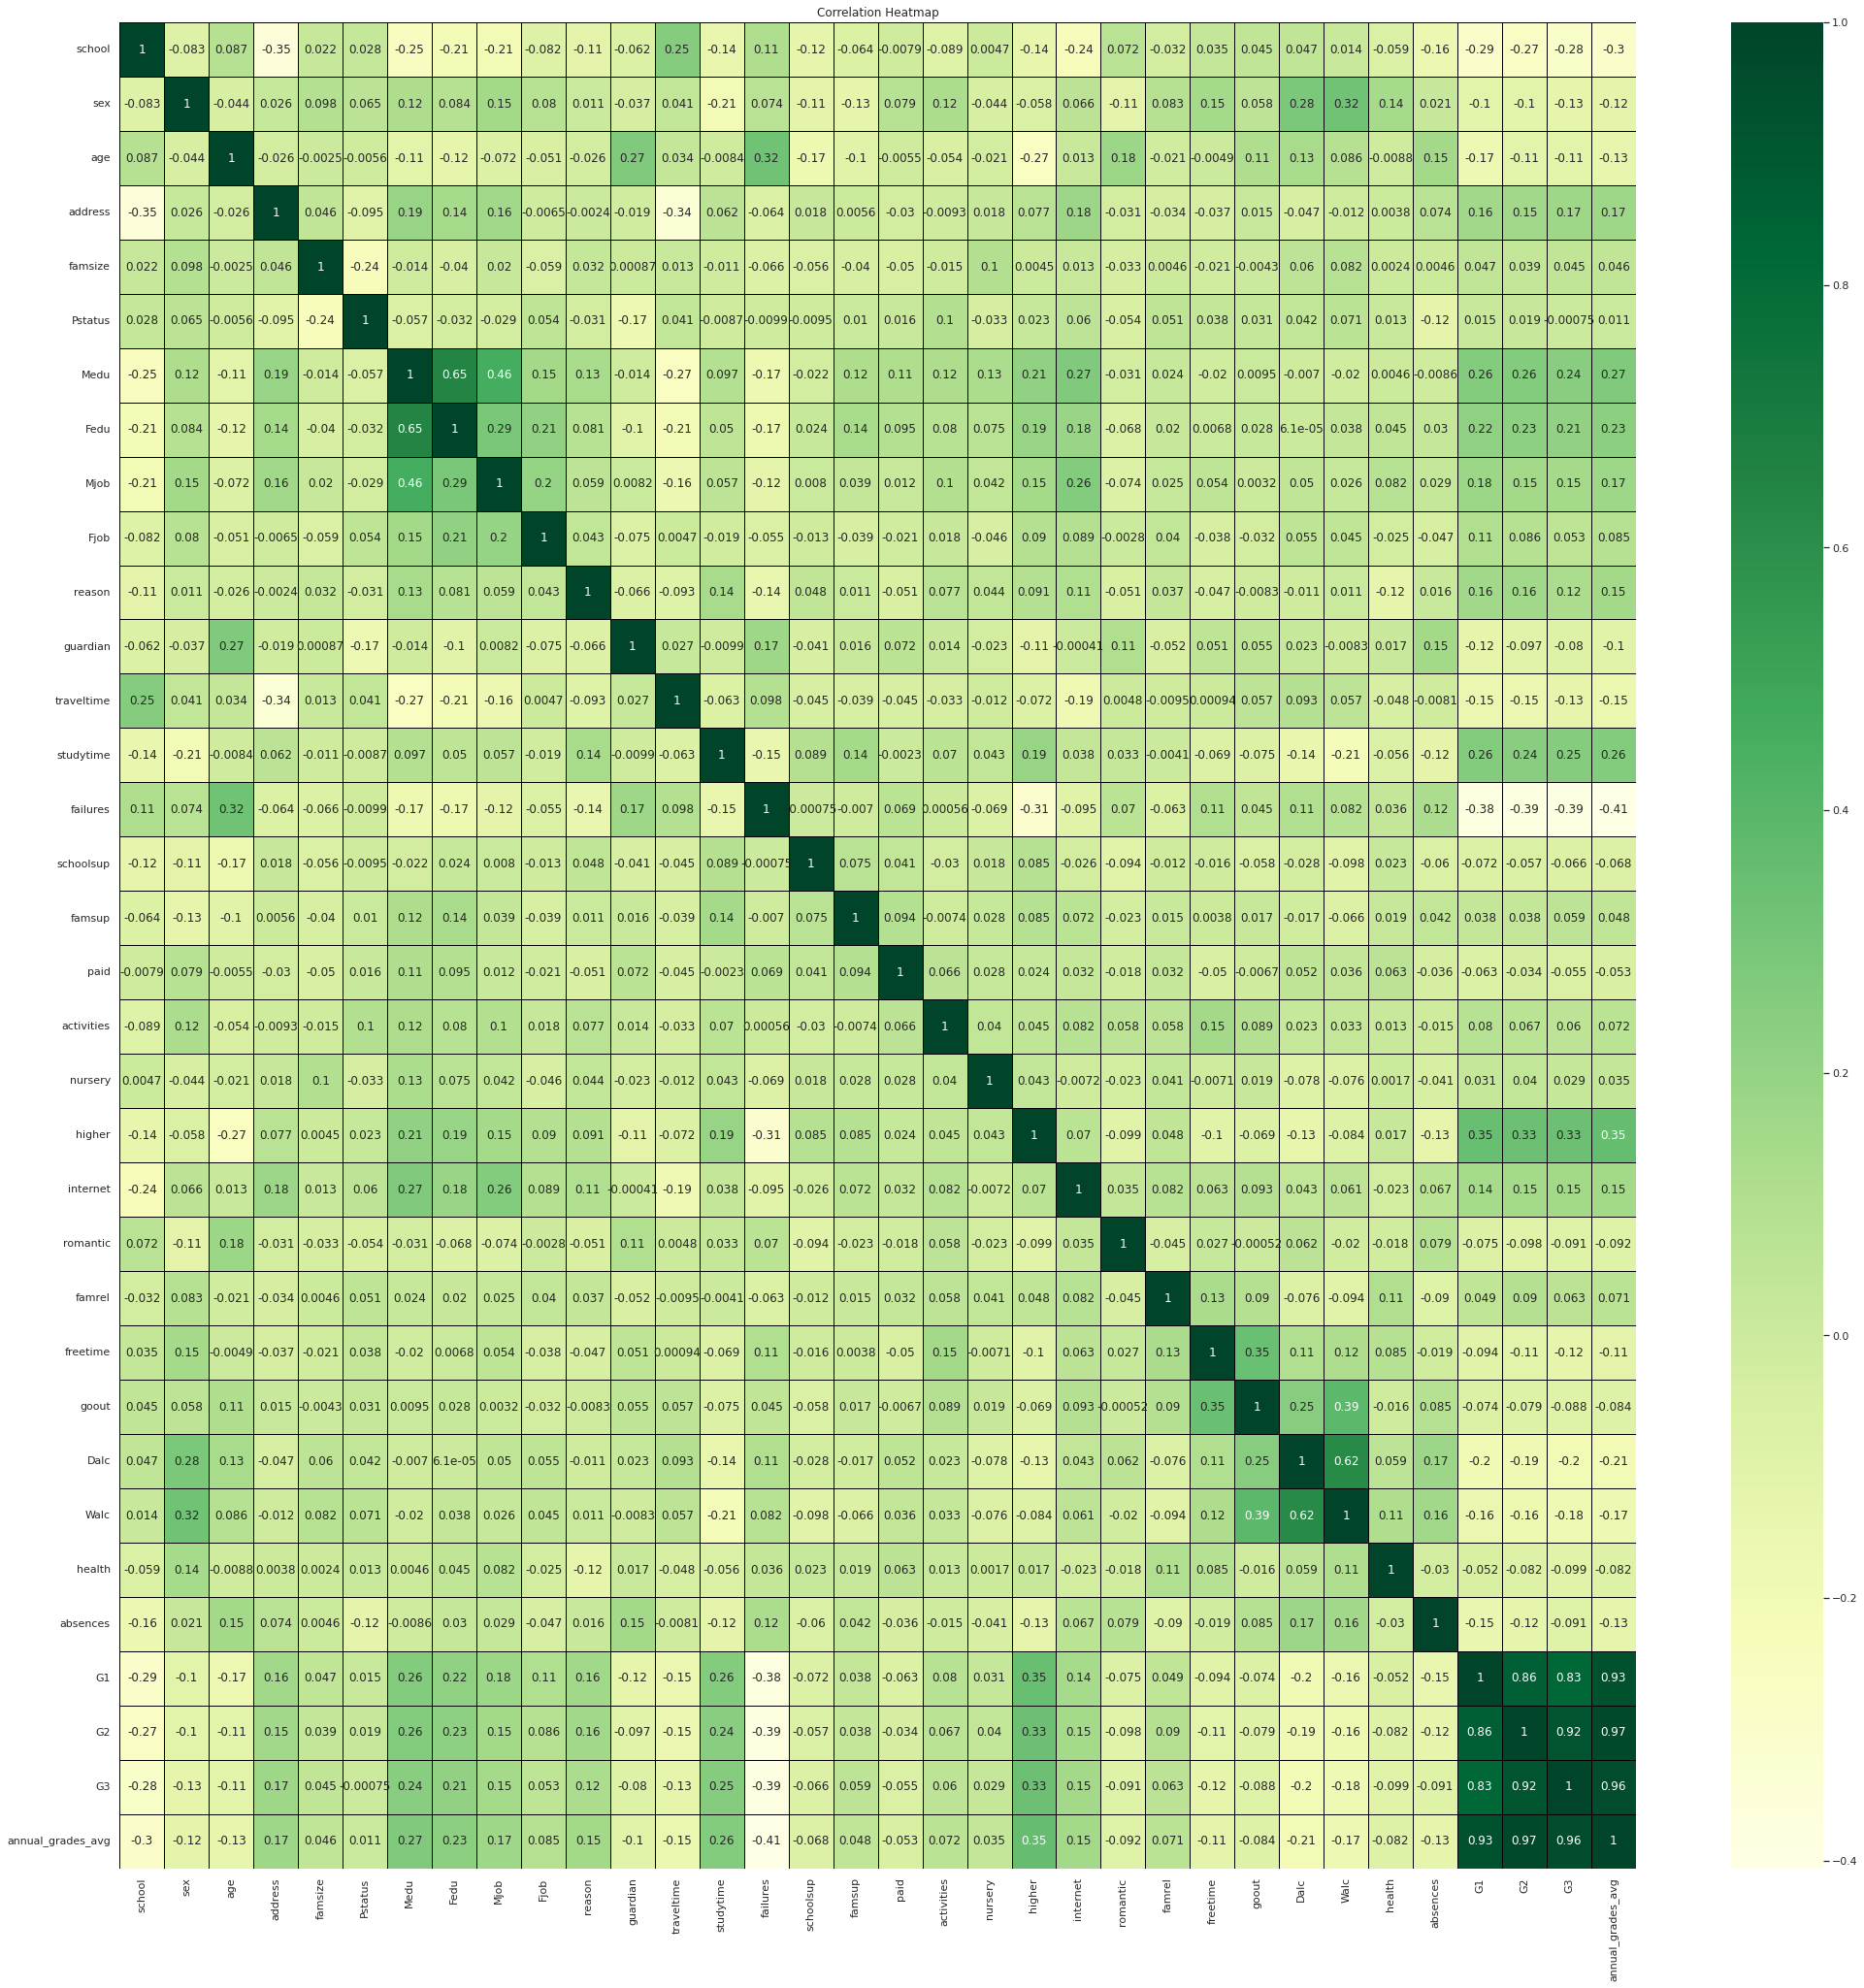

In [59]:
params = {'annot': True, 'fmt': '.2g', 'cmap': 'YlGn',
          'linewidths': 1, 'linecolor': 'black'}

# We need to encode the string nominal columns to numbers
encoded_df = students_grades_df.iloc[:, :-1].copy()
columns = encoded_df.select_dtypes(include=['object']).columns
ordinal_encoder = OrdinalEncoder()
encoded_df[columns] = ordinal_encoder.fit_transform(encoded_df[columns])

plot_corr_map(encoded_df, **params)


**So what we actually see here?**

- No one likes `school` - it has a low negative correlation with `address` & `annual_grades_avg`.

- `sex` has low positive correlation with `Walc`.

- `address` has low negative correlation with `traveltime`.

- Each `grade` is positively highly correlated with each other (and obviously wtih `annual_grades_avg` since that feature linearly dependent on those 3 **G1, G2 and G3 will be dropped before modeling**).

- `Medu` & `Fedu` have a medium positive correlation between them.

- `Medu` has a low positive correlation with `Mjob`.

- `age` has a low positive correlation with `failure`.

- `studytime` has a low positive correlation with each `grade`.

- `failrues` has a low negative correlation with `higher` & each `grade` (and the average).

- `higher` has a low positive correlation with each `grade` (and the average).

- Naturally, `freetime` has a low positive correlation with `goout`.

- And if you already are going out, why not have a drink? there is a low positive correlation between `goout` with `Walc`.

*Now lets get a better insight on our 5 level classification*

<a id="Categorical_Quantitative_Insights"></a>
## Categorical Quantitative Insights

In [60]:
def plot_categorical_insight(categorical_columns):

    nrows, ncols = categorical_columns.shape[1], 3
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 85))

    for idx, column in enumerate(categorical_columns):
        ax = axes[idx]
        sns.countplot(data=students_grades_df,
                      x='annual_grades_evaluation', hue=column, ax=ax[0])

        sns.countplot(data=students_grades_df, x=column, ax=ax[1])

        sns.boxplot(data=students_grades_df, x=column,
                    y='annual_grades_avg', ax=ax[2])


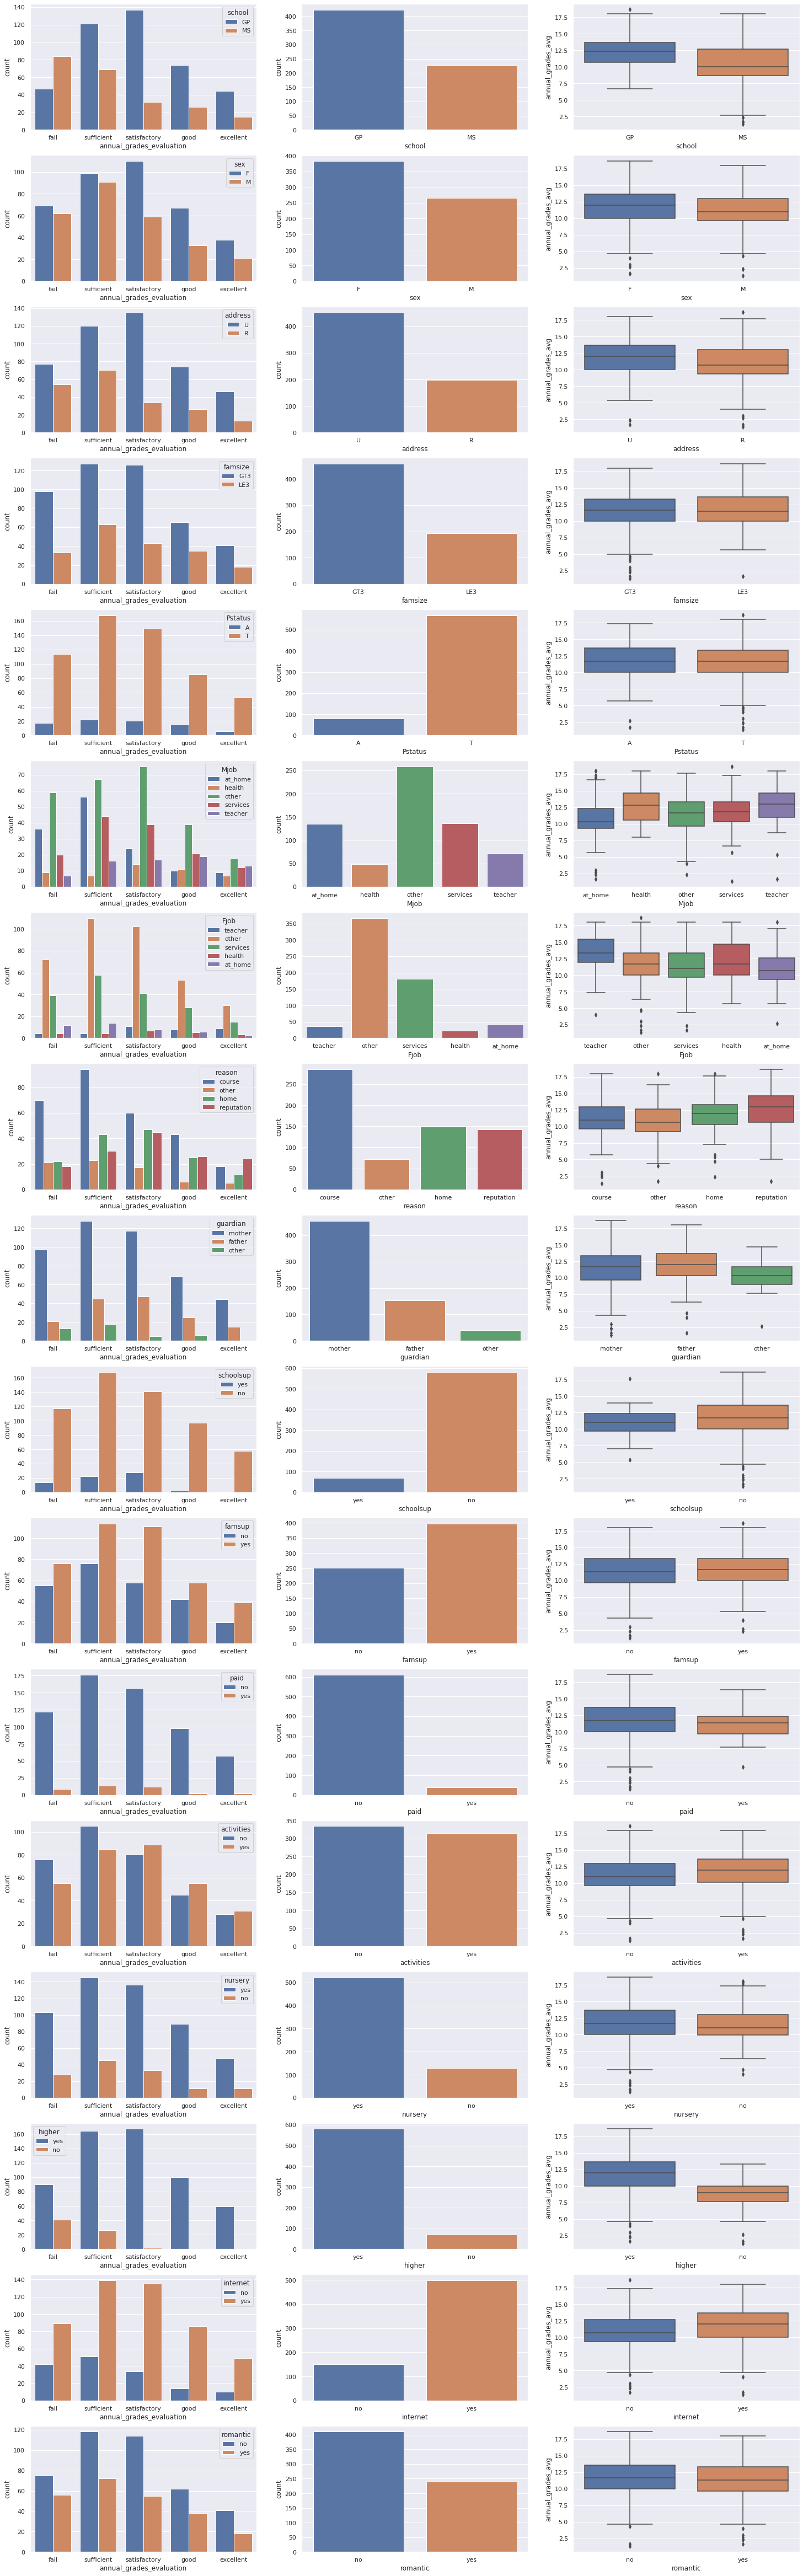

In [61]:
columns = students_grades_df.select_dtypes(include='object')
columns = columns.drop('annual_grades_evaluation', axis=1)
plot_categorical_insight(columns)


#### **Important note: all of the insights mentioned below should be taken in context to the amount we see of each label in the middle count plot.**


### **The main points that we can see are:**
- *One `school` comes out top in every metric (or comes out down in failures).*
- *`Females` do fail more than `males` but still do better overall in the other levels.*
- *Students living in an `urban `area perform better than those who live in a `rural` are.*
- *The `reputation` seems to be the main factor to choose a 'good' school.*
- *Students who engage in extracurricular `activities` have better grades than those who not.*

**And one final lookup:**

In [62]:
def plot_grades_to_self():
    nrows, ncols = 1, 2
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    sns.countplot(data=students_grades_df,
                  x='annual_grades_evaluation', ax=axes[0])

    sns.boxplot(data=students_grades_df,
                x='annual_grades_evaluation', y='annual_grades_avg', ax=axes[1])


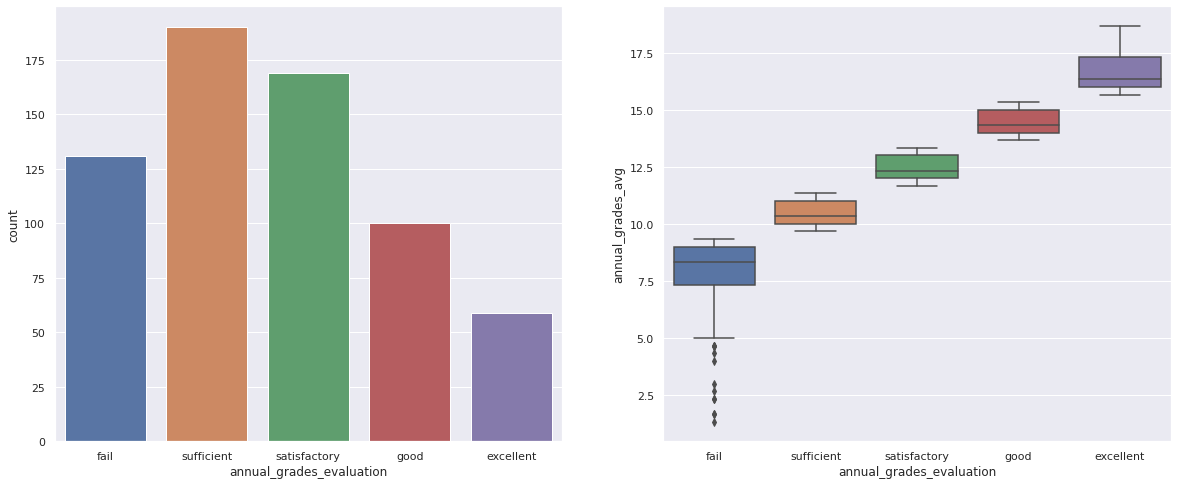

In [63]:
plot_grades_to_self()


*It seems like students just don't like school much thsese days & we have quite a few outliers below the `min` value of failures.*

<a id="Non_Categorical_Quantitative_Insights"></a>
## Non-Categorical Quantitative Insights

In [64]:
def plot_non_categorical_insight(non_categorical_columns):

    nrows, ncols = non_categorical_columns.shape[1], 2
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 100))

    for idx, column in enumerate(non_categorical_columns):
        ax = axes[idx]

        sns.scatterplot(data=students_grades_df, x=column,
                        y='annual_grades_avg', ax=ax[0], hue='annual_grades_evaluation')

        ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
                     ncol=5, fancybox=True, shadow=True)

        sns.boxplot(data=students_grades_df, x=column,
                    y='annual_grades_avg', ax=ax[1])


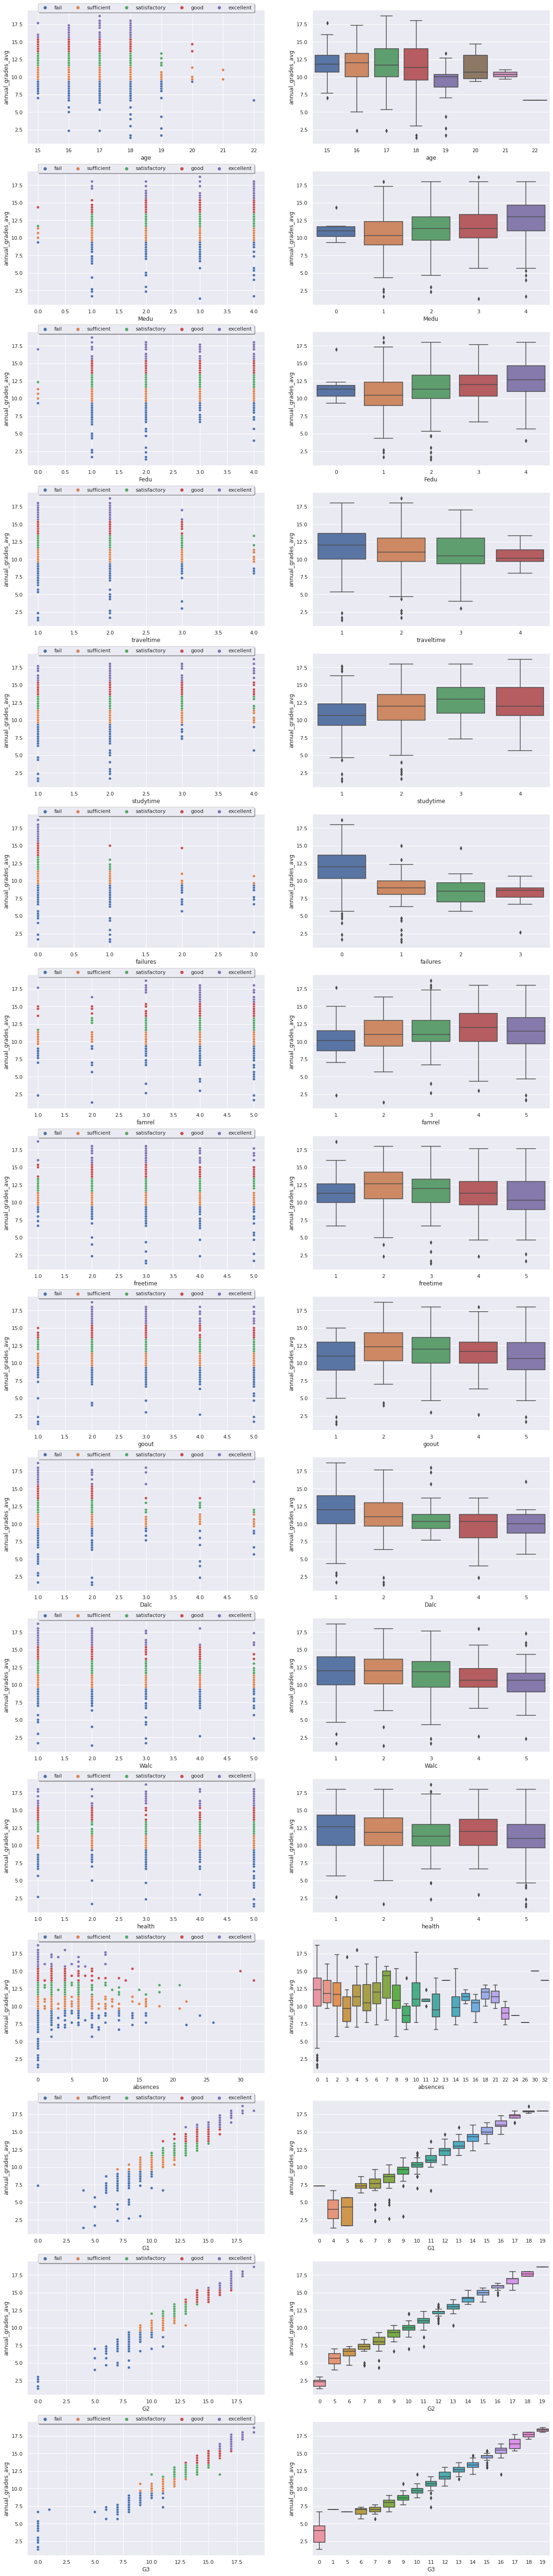

In [65]:
columns = students_grades_df.select_dtypes(include=['int64', 'float64'])
columns = columns.drop('annual_grades_avg', axis=1)
plot_non_categorical_insight(columns)


In [66]:
def boxplot_non_categorical(non_categorical_columns, colors):
    nrows, ncols = 4, 4
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

    for idx, sliced_columns in enumerate(non_categorical_columns):
        ax = axes[idx]

        for col_idx, (column, color) in enumerate(zip(sliced_columns, colors)):
            sns.boxplot(data=students_grades_df, x=column,
                        ax=ax[col_idx], color=color)


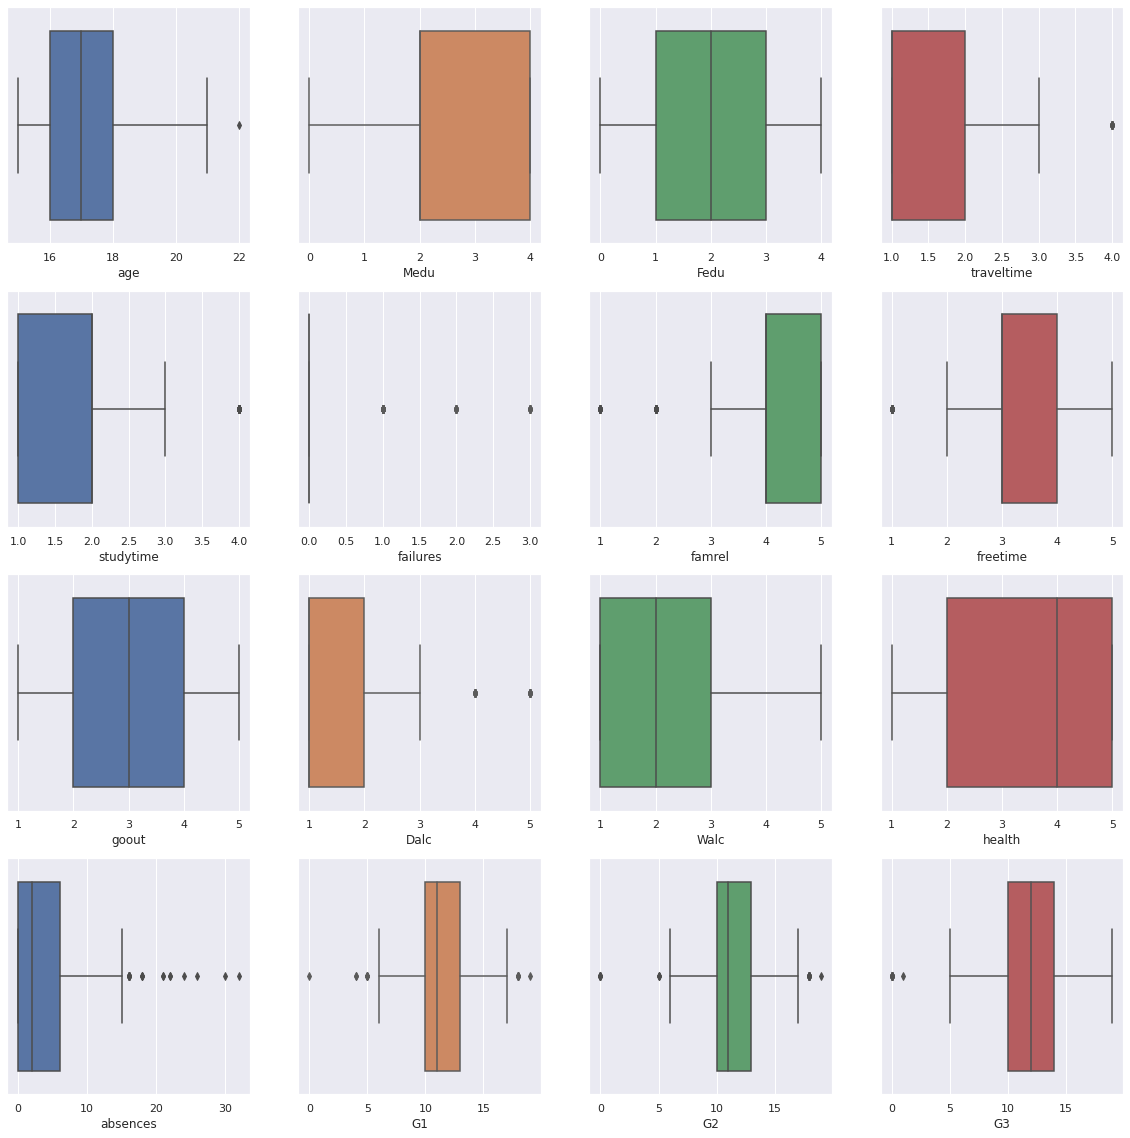

In [67]:
size = 4
sliced_columns = [column for column in columns]
sliced_columns = [sliced_columns[sliced-4:sliced]
                  for sliced in range(size, columns.shape[1] + 1, size)]

colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52']
boxplot_non_categorical(sliced_columns, colors)


### **The main points that we can see are:**
- That 22 years old student seems like an outlier.
- Students grades seems to be better if the level of education their parents have is higher (`Fedu` & `Medu`).
- Interestingly enough, the closer the student lives to the school - the better the grades.
- It's good to see that all excellent students `goout` in a certain level.
- Seems like you can't have `good` grades when your `absences` is more than 30 - outliers(?).
- As the year went along, more and more students failed in the exam & probably didn't even show up.
- For some reason, the `failures` boxplot returns a single line, lets examine it below.

In [68]:
students_grades_df['failures'].value_counts()


0    549
1     70
2     16
3     14
Name: failures, dtype: int64

*So because we have only 3 distinct values where one of them is way more frequent than the others, it is expected to happen.*

<a id="Skewness_Kurtosis"></a>
## Skewness & Kurtosis

In [ ]:
sns.displot(data=students_grades_df['annual_grades_avg'],
            element='step', kde=True, color='green')


In [ ]:
print(f"skewness: {students_grades_df['annual_grades_avg'].skew()}")
print(f"kurtosis: {students_grades_df['annual_grades_avg'].kurt()}")


*The column resembles a normal distribution, it has a low negative skewness which means the data is pretty much symetric.*

*We can derive for the kurtosis value that the data has some sort of peakedness.*

<a id="Outliers_Detection"></a>
# Outliers Detection

*But before we start, lets drop columns `G1`, `G2` & `G3`.*

In [ ]:
column_to_drop = ['G1', 'G2', 'G3']
students_grades_df = students_grades_df.drop(column_to_drop, axis=1)


In [ ]:
def detect_outliers(columns):
    outlier_indices = []
    for column in columns:
        Q1 = students_grades_df[column].quantile(0.25)
        Q3 = students_grades_df[column].quantile(0.75)
        IQR = Q3 - Q1  # IQR is interquartile range.

        mask = (students_grades_df[column] >= Q1 - 1.5 *
                IQR) & (students_grades_df[column] <= Q3 + 1.5 * IQR)
        mask = mask.to_numpy()
        false_indices = np.argwhere(~mask)
        outlier_indices.append(false_indices)
    return np.unique(np.concatenate(outlier_indices).ravel())


In [ ]:
numerical_columns = ['age', 'absences', 'annual_grades_avg']
outlier_indices = detect_outliers(numerical_columns)


In [ ]:
print(f'Number of outliers: {len(outlier_indices)}')


In [ ]:
# Delete outliers
students_grades_df = students_grades_df.drop(outlier_indices, axis=0)


<a id="Classification_Modeling"></a>
# Classification Modeling

**So, what he have in our menu?**
- For appetizers, we have a `Logistic Regression`, `Decision Tree Classifer` and `Support Vector Classifier`.
- For the main course, you can choose between:
    - `Random Forest Classifier`.
    - `AdaBoost Classifier`.
    - `Gradient Boosting Classifier`.
- And finally for deserts, we have either `KNN` or `Gussian Naive Bayes`.


In [ ]:
# Split dataset
X, y = students_grades_df.iloc[:, :-1], students_grades_df.iloc[:, -1]


<a id="Data_Scaling"></a>
## Data Scaling


In [ ]:
# First we need to know which columns are binary, nominal and numerical
def get_columns_by_category():
    categorical_mask = X.select_dtypes(
        include=['object']).apply(pd.Series.nunique) == 2
    numerical_mask = X.select_dtypes(
        include=['int64', 'float64']).apply(pd.Series.nunique) > 5

    binary_columns = X[categorical_mask.index[categorical_mask]].columns
    nominal_columns = X[categorical_mask.index[~categorical_mask]].columns
    numerical_columns = X[numerical_mask.index[numerical_mask]].columns

    return binary_columns, nominal_columns, numerical_columns


In [ ]:
binary_columns, nominal_columns, numerical_columns = get_columns_by_category()


In [ ]:
# Now we can create a column transformer pipeline
transformers = [('binary', OrdinalEncoder(), binary_columns),
                ('nominal', OneHotEncoder(), nominal_columns),
                ('numerical', StandardScaler(), numerical_columns)]

transformer_pipeline = ColumnTransformer(transformers, remainder='passthrough')


In [ ]:
# Starified k cross validation
Kfold = StratifiedKFold(n_splits=5)


*Lets stack up our classifiers:*

In [ ]:
RANDOM_STATE = 42
# I did tweak some of the hyperparameters with trial & error
classifiers = [LogisticRegression(max_iter=70, solver='sag', random_state=RANDOM_STATE),
               DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
               SVC(C=2, kernel='linear', random_state=RANDOM_STATE),
               RandomForestClassifier(
                   max_depth=7, min_samples_split=5, min_samples_leaf=5, random_state=RANDOM_STATE),
               AdaBoostClassifier(DecisionTreeClassifier(
                   max_depth=1, random_state=RANDOM_STATE), random_state=RANDOM_STATE),
               GradientBoostingClassifier(
                   learning_rate=0.005, n_estimators=30, random_state=RANDOM_STATE),
               KNeighborsClassifier(),
               GaussianNB(var_smoothing=1e-2)
               ]


In [ ]:
pipelines = [Pipeline([('transformer', transformer_pipeline), ('estimator', classifier)])
             for classifier in classifiers]


*Cross Validation time:*

In [ ]:
def cv_fit_models():
    results = []
    for pipeline in pipelines:
        cv_score = cross_validate(pipeline, X, y,
                                  scoring=scoring, cv=Kfold, return_train_score=True)

        train_accuracy = cv_score['train_acc'].mean() * 100
        test_accuracy = cv_score['test_acc'].mean() * 100
        test_std = cv_score['test_acc'].std() * 100
        test_precision = cv_score['test_precision'].mean() * 100
        test_recall = cv_score['test_recall'].mean() * 100
        results.append([train_accuracy, test_accuracy, test_std,
                        test_precision, test_recall])

    return np.array(results)


In [ ]:
scoring = {'acc': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro'}

classifiers_names = ['Logistic Regression',
                     'Decision Tree Classifier',
                     'Support Vector Machine',
                     'Random Forest Classifier',
                     'AdaBoost Classifier',
                     'Gradient Boosting Classifier',
                     'K Neighbors Classifier',
                     'Gaussian Naive Bayes'
                     ]

results = cv_fit_models()


*Lets plot our results:*

In [ ]:
def plot_train_test_accuracy():
    _, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
    sns.barplot(data=results_df, x='train_accuracy',
                y='Model', orient='h', ax=ax[0])
    ax[0].set_xlim([0, 100])
    sns.barplot(data=results_df, x='test_accuracy',
                y='Model', orient='h', ax=ax[1], **{'xerr': results_df['test_std']})
    ax[1].set_xlim([0, 100])


In [ ]:
results_df = pd.DataFrame({'Model': classifiers_names,
                           'train_accuracy': results[:, 0],
                           'test_accuracy': results[:, 1],
                           'test_std': results[:, 2],
                           'test_precision': results[:, 3],
                           'test_recall': results[:, 4]})


In [ ]:
plot_train_test_accuracy()


In [ ]:
def plot_precision_recall():
    _, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
    sns.barplot(data=results_df, x='test_precision',
                y='Model', orient='h', ax=ax[0])
    ax[0].set_xlim([0, 100])
    sns.barplot(data=results_df, x='test_recall',
                y='Model', orient='h', ax=ax[1])
    ax[1].set_xlim([0, 100])


In [ ]:
plot_precision_recall()


<a id="Conclusions"></a>
# Conclusions:
- ### **Decision Tree Classifier, SVM & Gradient Boosting seem to give us the better results, especially SVM when we look at the precision & recall metrics.**
- ### **SVM & Logistic Regression probably overfits the data, we have only 649 rows (with outliers) and 31 columns, for this amount of features we really need way more 'meat' for our models to fit properly.**
- ### **Distance based model? big NO.**

## What can I try in the future?
- ### **Maybe not drop the outliers, or change the criteria for the minimum amount needed to be considered as an 'outlier' (now it's on 1).**
- ### **I doubt feature reduction will help here, but still can be given a shot.**
- ### **GridSearchCV to tune our hyperparameters.**